https://blog.csdn.net/amao1998/article/details/116061920

如果tf可以用，尝试一下上面的代码ho。

https://developer.apple.com/forums/thread/693292 之前一直有问题，后来参考了这个，卸掉了一个库，就好了。

In [1]:
import tensorflow as tf
tf.__version__

'2.7.0'

In [4]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 545.3/545.3 KB 157.1 kB/s eta 0:00:0000:0100:01


In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras
 
import re
# import jieba
# import opencc
import io

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [3]:
#cc = opencc.OpenCC('t2s')
def preprocess_sentence_cn(w):
  #将繁体字转换为简体字  
    # w = cc.convert(w)
    w = ' '.join(list(w))
    w = re.sub(r'[" "]+', " ", w)
    w = w.strip().rstrip()
    w = '<start> ' + w + ' <end>'
    return w

In [4]:
def create_dataset(path):
    lines = io.open(path,encoding='utf8').read().strip().split('\n')
    sentence_pairs = [[preprocess_sentence_cn(w) for w in line.replace("，","。").replace("。", " ").strip().split(' ')] for line in lines]
    return zip(*sentence_pairs)
train,targ=create_dataset('originalDataset/poem5.txt')

In [5]:
print(len(train),len(targ))
print(train[0],targ[0])

31072 31072
<start> 琴 书 中 有 得 <end> <start> 衣 食 外 何 求 <end>


In [6]:
def tokenize(lang):
    tokenizer=keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(lang)
    tensor=tokenizer.texts_to_sequences(lang)
    tensor=keras.preprocessing.sequence.pad_sequences(tensor,padding='post')
    return tensor,tokenizer
def load_dataset(inp_lang,targ_lang):
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [7]:
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(train,targ)
for item in input_tensor[0]:
    print('%d ---> %s'%(item,inp_lang.index_word[item]))
print("===================================================")
for item in target_tensor[0]:
    print('%d ---> %s'%(item,targ_lang.index_word[item]))

1 ---> <start>
393 ---> 琴
230 ---> 书
33 ---> 中
11 ---> 有
65 ---> 得
2 ---> <end>
1 ---> <start>
149 ---> 衣
828 ---> 食
224 ---> 外
12 ---> 何
503 ---> 求
2 ---> <end>


In [8]:
def max_length(tensor):
    return max(len(t) for t in tensor)
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [9]:
from sklearn.model_selection import train_test_split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val=sklearn.model_selection.train_test_split(input_tensor,target_tensor,test_size=0.2)

In [10]:
# 定义缓冲区大小 2000
BUFFER_SIZE = len(input_tensor_train)
#定义批次内数据量
BATCH_SIZE = 512
#定义每一轮训练需要经过多少批次
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE

In [11]:
# 定义字典大小,由于字典本身从1开始,0默认作为padding元素所以真正的字典大小需要加1
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

In [12]:
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train))# .shuffle(BUFFER_SIZE)

In [13]:
dataset = dataset.cache()

In [14]:
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [15]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

2022-05-18 04:24:10.951216: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(TensorShape([512, 7]), TensorShape([512, 7]))

# 3

In [16]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
 
    # 将 sin 应用于数组中的偶数索引（indices）；2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
 
    # 将 cos 应用于数组中的奇数索引；2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
 
    pos_encoding = angle_rads[np.newaxis, ...]
 
    return tf.cast(pos_encoding, dtype=tf.float32)

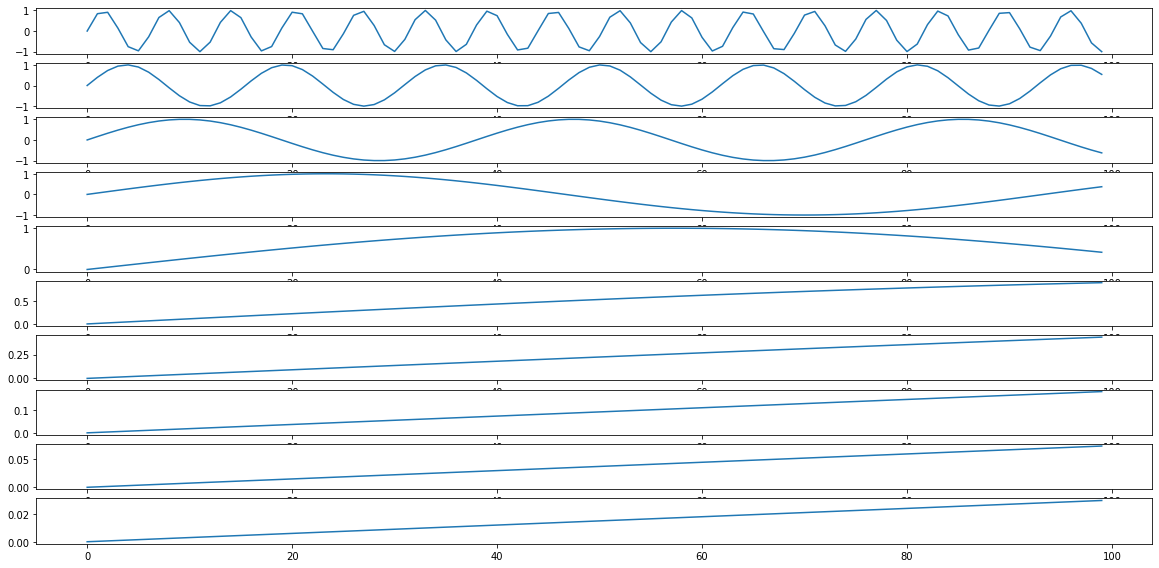

In [17]:
poscode=positional_encoding(100,512).numpy()
poscode=poscode[0]
x=np.arange(100)
plt.figure(figsize=(20,100))
j=1
for i in np.arange(0,500,50):
    plt.subplot(100,1,j)
    j+=1
    plt.plot(x,poscode[:,i])
plt.show()

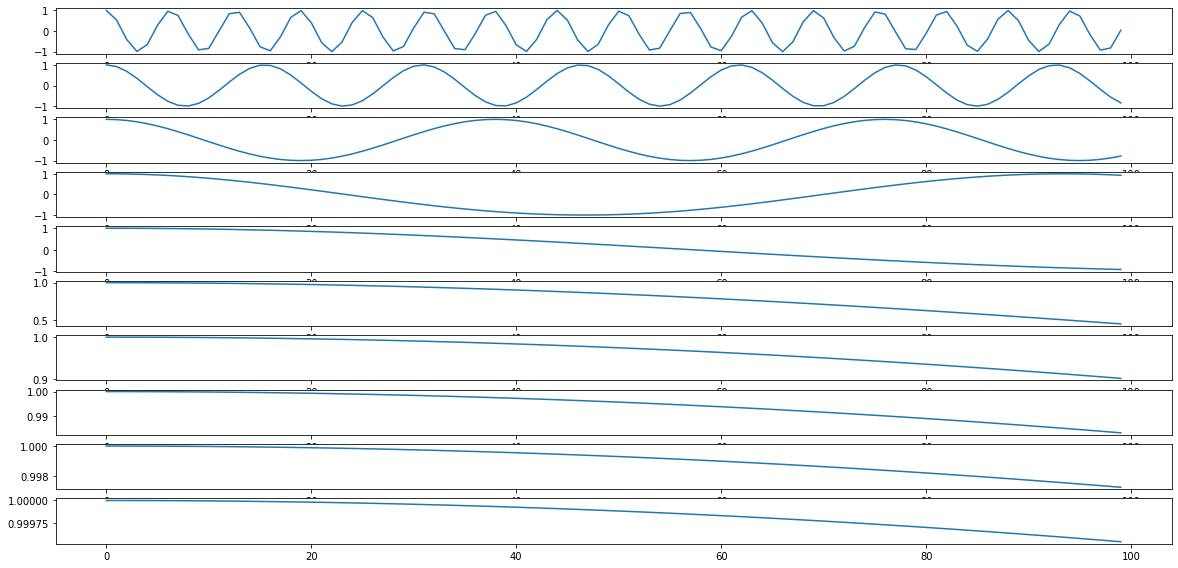

In [18]:
plt.figure(figsize=(20,100))
j=1
for i in np.arange(0,500,50):
    plt.subplot(100,1,j)
    j+=1
    plt.plot(x,poscode[:,i+1])
plt.show()

In [19]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
 
    # 添加额外的维度来将填充加到
    # 注意力对数（logits）。
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [20]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

In [21]:
def scaled_dot_product_attention(q, k, v, mask):
    """计算注意力权重。
    q, k, v 必须具有匹配的前置维度。
    k, v 必须有匹配的倒数第二个维度，例如：seq_len_k = seq_len_v。
    虽然 mask 根据其类型（填充或前瞻）有不同的形状，
    但是 mask 必须能进行广播转换以便求和。
    参数:
    q: 请求的形状 == (..., seq_len_q, depth)
    k: 主键的形状 == (..., seq_len_k, depth)
    v: 数值的形状 == (..., seq_len_v, depth_v)
    mask: Float 张量，其形状能转换成
          (..., seq_len_q, seq_len_k)。默认为None。
    返回值:
    输出，注意力权重
    """
#     print('k shape',k.shape)
#     print('q shape',q.shape)
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
#     print('qk shape',matmul_qk.shape)
    # 缩放 matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    # 将 mask 加入到缩放的张量上。
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  
#     print('scaled_attention_logis',scaled_attention_logits)
    # softmax 在最后一个轴（seq_len_k）上归一化，因此分数
    # 相加等于1。
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
 
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)
 
    return output, attention_weights

In [22]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
    print ('Attention weights are:')
    print (temp_attn)
    print ('Output is:')
    print (temp_out)

In [23]:
np.set_printoptions(suppress=True)
 
temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)
 
temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)
 
# 这条 `请求（query）符合第二个`主键（key）`，
# 因此返回了第二个`数值（value）`。
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [24]:
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [25]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
 
        assert d_model % self.num_heads == 0
 
        self.depth = d_model // self.num_heads
 
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
 
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """分拆最后一个维度到 (num_heads, depth).
        转置结果使得形状为 (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
 
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)
#         print(q.shape)
#         print(k.shape)
#         print(v.shape)
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
#         print(q.shape)
#         print(k.shape)
#         print(v.shape)
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)
#         print(scaled_attention)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
 
        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)
 
        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
 
        return output, attention_weights

In [26]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)

In [27]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

In [28]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

In [29]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,d_model,num_heads,dff,rate=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model,num_heads)
        self.ffn = point_wise_feed_forward_network(d_model,dff)
        self.layernorm1=tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2=tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1=tf.keras.layers.Dropout(rate)
        self.dropout2=tf.keras.layers.Dropout(rate)
    def __call__(self,x,training, mask):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1+ffn_output)
        return out2 # (batch_size, input_seq_len, d_model)

In [30]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,d_model,num_heads,dff,rate=0.1):
        super(DecoderLayer, self).__init__()
        self.mha1=MultiHeadAttention(d_model,num_heads)
        self.mha2=MultiHeadAttention(d_model,num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
 
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    def __call__(self,x,enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, input_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)  # (batch_size, input_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
        
        ffn_output=self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)
        return out3,attn_weights_block1,attn_weights_block2

In [31]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    def __call__(self,x,training, mask):
        seq_len = tf.shape(x)[1]
        x=self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32)) #???
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
    
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
 
        return x  # (batch_size, input_seq_len, d_model)

In [32]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()
 
        self.d_model = d_model
        self.num_layers = num_layers
 
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
 
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        
        seq_len = tf.shape(x)[1]
        attention_weights = {}
 
        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
 
        x = self.dropout(x, training=training)
 
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)
 
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
 
        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [33]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()
 
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                               input_vocab_size, pe_input, rate)
 
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                               target_vocab_size, pe_target, rate)
 
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
 
        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
 
        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)
 
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
 
        return final_output, attention_weights

In [34]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
 
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
 
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
 
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

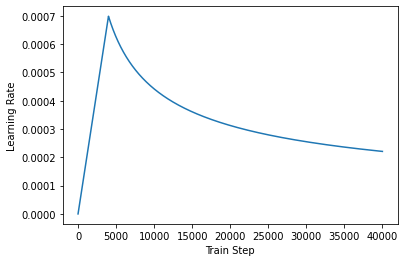

In [35]:
d_model = 512


learning_rate = CustomSchedule(d_model)
 
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)
temp_learning_rate_schedule = CustomSchedule(d_model)
 
plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [36]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
 
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
 
    return tf.reduce_mean(loss_)
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [37]:
transformer = Transformer(6, d_model, 8, 512,
                          vocab_inp_size, vocab_tar_size, 
                          pe_input=vocab_inp_size, 
                          pe_target=vocab_tar_size,
                          rate=0.5)
# transformer = Transformer(num_layers, d_model, num_heads, dff,
#                           input_vocab_size, target_vocab_size, 
#                           pe_input=input_vocab_size, 
#                           pe_target=target_vocab_size,
#                           rate=dropout_rate)

In [38]:
def create_masks(inp, tar):
    # 编码器填充遮挡
    enc_padding_mask = create_padding_mask(inp)
 
    # 在解码器的第二个注意力模块使用。
    # 该填充遮挡用于遮挡编码器的输出。
    dec_padding_mask = create_padding_mask(inp)
 
    # 在解码器的第一个注意力模块使用。
    # 用于填充（pad）和遮挡（mask）解码器获取到的输入的后续标记（future tokens）。
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
 
    return enc_padding_mask, combined_mask, dec_padding_mask

In [39]:
example_train,example_tar=next(iter(dataset))
enc_padding_mask, combined_mask, dec_padding_mask=create_masks(example_train,example_tar)
print(enc_padding_mask.shape,dec_padding_mask.shape,combined_mask.shape)

(512, 1, 1, 7) (512, 1, 1, 7) (512, 1, 7, 7)


2022-05-18 04:24:11.964879: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [40]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
]
 
@tf.function(input_signature=train_step_signature)
def train_step(inp,tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
#     config = tf.ConfigProto(allow_soft_placement = True)
#     sess = tf.Session(config = config)
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     True, 
                                     enc_padding_mask, 
                                     combined_mask, 
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)
    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
 
    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [47]:
EPOCHS = 5
for epoch in range(EPOCHS):
    start = time.time()
 
    train_loss.reset_states()
    train_accuracy.reset_states()
  
  # inp -> portuguese, tar -> english
    for (batch, (inp, tar)) in enumerate(dataset):
        train_step(inp, tar)
    
        if batch % 50 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, batch, train_loss.result(), train_accuracy.result()))
        if batch == 5:
            break
           
    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                        train_loss.result(), 
                                        train_accuracy.result()))
 
    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 6.2601 Accuracy 0.1667


2022-05-18 04:31:55.089811: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 1 Loss 6.2450 Accuracy 0.1667
Time taken for 1 epoch: 13.362266778945923 secs

Epoch 2 Batch 0 Loss 6.2264 Accuracy 0.1667


2022-05-18 04:32:08.243140: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 2 Loss 6.2136 Accuracy 0.1667
Time taken for 1 epoch: 13.152314186096191 secs

Epoch 3 Batch 0 Loss 6.1676 Accuracy 0.1667


2022-05-18 04:32:21.484517: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 3 Loss 6.1884 Accuracy 0.1667
Time taken for 1 epoch: 13.239125967025757 secs

Epoch 4 Batch 0 Loss 6.1651 Accuracy 0.1667


2022-05-18 04:32:36.852370: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 4 Loss 6.1573 Accuracy 0.1667
Time taken for 1 epoch: 15.36843204498291 secs

Epoch 5 Batch 0 Loss 6.1288 Accuracy 0.1667
Epoch 5 Loss 6.1315 Accuracy 0.1667
Time taken for 1 epoch: 13.003317832946777 secs



2022-05-18 04:32:49.861574: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [48]:
def evaluate(inp_sentence):
    
    encoder_input = tf.expand_dims(inp_sentence, 0)
 
    decoder_input = [1]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(7):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)
  
        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
        # 从 seq_len 维度选择最后一个词
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)
 
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
        # 如果 predicted_id 等于结束标记，就返回结果
        if predicted_id == 2:
              return tf.squeeze(output, axis=0), attention_weights
    
        # 连接 predicted_id 与输出，作为解码器的输入传递到解码器。
        output = tf.concat([output, predicted_id], axis=-1)
 
    return tf.squeeze(output, axis=0), attention_weights

In [49]:
import random
def convert(lang, tensor):
    result=[]
    for t in tensor:
        result.append(lang.index_word[t])
    return ''.join(result)
def chooce_val():
    max_len=len(input_tensor_val)
    rand_index=random.sample(range(max_len),100)
    val_train=input_tensor_val[rand_index]
    val_targ=target_tensor_val[rand_index]
    for _index in range(100):
        print('上一句')
        print(convert(inp_lang,val_train[_index]))
        print('真实')
        print(convert(targ_lang,val_targ[_index]))
        print('生成')
        output,att_weight=evaluate(val_train[_index])
        print(convert(targ_lang,output.numpy()))
        print('===============================================')

In [50]:
chooce_val()

上一句
<start>宫兰非瑶草<end>
真实
<start>安得春长在<end>
生成
<start>
上一句
<start>未得青云志<end>
真实
<start>春同秋日情<end>
生成
<start>
上一句
<start>别后风清夜<end>
真实
<start>思君蜀路难<end>
生成
<start>
上一句
<start>为我谢此僧<end>
真实
<start>终当理归策<end>
生成
<start>
上一句
<start>分飞来几时<end>
真实
<start>秋夏炎凉变<end>
生成
<start>
上一句
<start>青春浩无际<end>
真实
<start>白日乃迟迟<end>
生成
<start>
上一句
<start>荒馆因花宿<end>
真实
<start>深山羡客回<end>
生成
<start>
上一句
<start>浮客转危坐<end>
真实
<start>归舟应独行<end>
生成
<start>
上一句
<start>故国思如此<end>
真实
<start>若为天外心<end>
生成
<start>
上一句
<start>夜深方独卧<end>
真实
<start>谁为拂尘床<end>
生成
<start>
上一句
<start>风头难著枕<end>
真实
<start>病眼厌看书<end>
生成
<start>
上一句
<start>迷津欲有问<end>
真实
<start>平海夕漫漫<end>
生成
<start>
上一句
<start>长空横海色<end>
真实
<start>断岸落潮声<end>
生成
<start>
上一句
<start>人生能几何<end>
真实
<start>莫厌相逢遇<end>
生成
<start>
上一句
<start>相对唯溪寺<end>
真实
<start>初宵闻念经<end>
生成
<start>
上一句
<start>不见侵山叶<end>
真实
<start>空闻拂地枝<end>
生成
<start>
上一句
<start>长风吹白茅<end>
真实
<start>野火烧枯桑<end>
生成
<start>
上一句
<start>雪暗穷海云<end>
真实
<start>洒空纷似露<end>
生成
<start>
上一句
<start>别恨双溪急<end>
真实
<st

<start>
上一句
<start>野人头尽白<end>
真实
<start>与我忽相访<end>
生成
<start>
上一句
<start>万里千山路<end>
真实
<start>何因欲寄书<end>
生成
<start>
上一句
<start>白衣经乱世<end>
真实
<start>相遇一开颜<end>
生成
<start>
上一句
<start>庭阴残旧雪<end>
真实
<start>柳色带新年<end>
生成
<start>
上一句
<start>田家几日闲<end>
真实
<start>耕种从此起<end>
生成
<start>
上一句
<start>何处山不幽<end>
真实
<start>此中情又别<end>
生成
<start>
上一句
<start>惊舟同厌夜<end>
真实
<start>独树对悲秋<end>
生成
<start>
上一句
<start>赤白徒自许<end>
真实
<start>幽芳谁与论<end>
生成
<start>
上一句
<start>东门车马路<end>
真实
<start>此路在浮沉<end>
生成
<start>
上一句
<start>日暮天地冷<end>
真实
<start>雨霁山河清<end>
生成
<start>
上一句
<start>自尔宴言后<end>
真实
<start>至今门馆清<end>
生成
<start>
上一句
<start>闲云生不雨<end>
真实
<start>病叶落非秋<end>
生成
<start>
上一句
<start>老过离乱世<end>
真实
<start>生在太平时<end>
生成
<start>
上一句
<start>樵人应满郭<end>
真实
<start>仙鸟几巢林<end>
生成
<start>
上一句
<start>故人得佳句<end>
真实
<start>独赠白头翁<end>
生成
<start>
上一句
<start>南图适不就<end>
真实
<start>东走岂吾心<end>
生成
<start>
上一句
<start>若人不世生<end>
真实
<start>悠悠多如彼<end>
生成
<start>
上一句
<start>浪迹未出世<end>
真实
<start>空名动京师<end>
生成
<start>
